In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from mlxtend.plotting import plot_decision_regions

from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


---

### 1. Cleaning the data, sampling a subset of the data, balancing the subset, encoding categorical values and changing 
### labels from string to numeric

In [2]:
from sklearn.datasets import fetch_kddcup99
pd.options.display.max_columns = None
data = fetch_kddcup99(percent10=True, as_frame=True)["frame"]
data = data.drop_duplicates();
print(data.head())

  duration protocol_type  service   flag src_bytes dst_bytes land  \
0        0        b'tcp'  b'http'  b'SF'       181      5450    0   
1        0        b'tcp'  b'http'  b'SF'       239       486    0   
2        0        b'tcp'  b'http'  b'SF'       235      1337    0   
3        0        b'tcp'  b'http'  b'SF'       219      1337    0   
4        0        b'tcp'  b'http'  b'SF'       217      2032    0   

  wrong_fragment urgent hot num_failed_logins logged_in num_compromised  \
0              0      0   0                 0         1               0   
1              0      0   0                 0         1               0   
2              0      0   0                 0         1               0   
3              0      0   0                 0         1               0   
4              0      0   0                 0         1               0   

  root_shell su_attempted num_root num_file_creations num_shells  \
0          0            0        0                  0          0  

In [3]:
encoder = OneHotEncoder()

#encoding protocol_type
encoded_data = encoder.fit_transform(data[['protocol_type']])
encoded_data_array = encoded_data.toarray()
encoded_data_df = pd.DataFrame(encoded_data_array, columns=encoder.get_feature_names_out(['protocol_type']))
df_final = pd.concat([data.drop(['protocol_type'], axis=1), encoded_data_df], axis=1)

#encoding service
encoded_data = encoder.fit_transform(df_final[['service']])
encoded_data_array = encoded_data.toarray()
encoded_data_df = pd.DataFrame(encoded_data_array, columns=encoder.get_feature_names_out(['service']))
df_final = pd.concat([df_final.drop(['service'], axis=1), encoded_data_df], axis=1)

#encoding flag
encoded_data = encoder.fit_transform(df_final[['flag']])
encoded_data_array = encoded_data.toarray()
encoded_data_df = pd.DataFrame(encoded_data_array, columns=encoder.get_feature_names_out(['flag']))
df_final = pd.concat([df_final.drop(['flag'], axis=1), encoded_data_df], axis=1)

print(df_final.shape)
print(df_final.head())

data=df_final

(317205, 121)
  duration src_bytes dst_bytes land wrong_fragment urgent hot  \
0        0       181      5450    0              0      0   0   
1        0       239       486    0              0      0   0   
2        0       235      1337    0              0      0   0   
3        0       219      1337    0              0      0   0   
4        0       217      2032    0              0      0   0   

  num_failed_logins logged_in num_compromised root_shell su_attempted  \
0                 0         1               0          0            0   
1                 0         1               0          0            0   
2                 0         1               0          0            0   
3                 0         1               0          0            0   
4                 0         1               0          0            0   

  num_root num_file_creations num_shells num_access_files num_outbound_cmds  \
0        0                  0          0                0                 0  

In [4]:
#Finding the count of rows that have NaN or missing values
missing_values = data.isna()
rows_with_missing_values = missing_values.sum(axis=1) > 0
count_rows_with_missing_values = rows_with_missing_values.sum()
print("Count of Rows with One or More Missing Values:", count_rows_with_missing_values)

Count of Rows with One or More Missing Values: 230958


In [5]:
#checking count of NaN values per column
nan_count_per_column = data.isna().sum()
print("Count of NaN Values in Each Column:")
print(nan_count_per_column)
#dropping rows with null values
#Even though the number of rows with NaN values is high, I chose to impute that data as it is better than replacing it with zeroes or median without
#having the proper knowledge of what the central tendency of that field should look like
df_cleaned = data.dropna()
nan_count_per_column = df_cleaned.isna().sum()
print(df_cleaned.shape)
#Verifying the count of NaN values in each column after imputing missing data rows
print("Count of NaN Values in Each Column:")
print(nan_count_per_column)
data=df_cleaned

Count of NaN Values in Each Column:
duration          171619
src_bytes         171619
dst_bytes         171619
land              171619
wrong_fragment    171619
                   ...  
flag_b'S2'         56140
flag_b'S3'         56140
flag_b'SF'         56140
flag_b'SH'         56140
flag_nan           56140
Length: 121, dtype: int64
(86247, 121)
Count of NaN Values in Each Column:
duration          0
src_bytes         0
dst_bytes         0
land              0
wrong_fragment    0
                 ..
flag_b'S2'        0
flag_b'S3'        0
flag_b'SF'        0
flag_b'SH'        0
flag_nan          0
Length: 121, dtype: int64


In [6]:
#Marking the dos attacks as 1 and non-dos attacks as 0
data['labels'] = data['labels'].replace([b'back.', b'land.', b'neptune.', b'pod.', b'smurf.', b'teardrop.'], 1, inplace=False)
data['labels'] = data['labels'].apply(lambda x: 0 if x != 1 else x)
print(data.shape)
#taking a 50% sample of the data to save computational power
data = data.sample(frac=0.5, random_state=42)
print(data['labels'].unique())
print(data['labels'].value_counts())

(86247, 121)
[0 1]
0    34343
1     8781
Name: labels, dtype: int64


<ipython-input-6-f23f317e70f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'] = data['labels'].replace([b'back.', b'land.', b'neptune.', b'pod.', b'smurf.', b'teardrop.'], 1, inplace=False)
<ipython-input-6-f23f317e70f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['labels'] = data['labels'].apply(lambda x: 0 if x != 1 else x)


In [7]:
#Creating X as a dataframe of features and y as a dataframe of labels
X = data.drop(columns=['labels'])
y = data['labels']

#sampling the data to ensure a balanced training and testing set
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=10)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)
y_resampled.value_counts()

0    8781
1    8781
Name: labels, dtype: int64

In [8]:
# Scaling the data using MinMaxScaler
scaler=MinMaxScaler()
X_resampled=scaler.fit_transform(X_resampled)

In [9]:
#splitting the resampled data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


---

### 2. Running the 4 kernels of SVM and comparing their results

In [10]:
#Training the SVM using the linear kernel
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9923142613151152


In [11]:
#Training the SVM using the polynomial kernel
svm_model = SVC(kernel='poly',C=0.5,gamma=0.7)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9988613720466838


In [12]:
#Training the SVM using the rbf kernel
svm_model = SVC(kernel='rbf',C=10,gamma=0.7)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9982920580700256


In [13]:
#Training the SVM using the sigmoid kernel
svm_model = SVC(kernel='sigmoid',gamma=0.05)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9644178764588671


### The accuracies for the 4 kernels are as follows:
#### Linear: 0.9923 
##### Pros: 
##### a) It is a simple kernel which works well with linearly seperable data. In this case it provides good accuracy which means the data is largely linearly seperable.
##### b) It is computationally simple so it is faster as compared to other kernels.
##### Cons: 
##### a) Doesn't work well with linearly inseperable data.
#### Polynomial:0.9988 
##### Pros:
##### a) It is able to draw the decision boundary as a polynomial function. So, it can work with linearly inseperable data as well.
##### Cons:
##### a) Computationally expensive.
##### b) Cannot optimally classify data that can't be seperated by polynomial functions 
#### RBF: 0.9982
##### Pros:
##### a) BF kernels are highly flexible and can capture complex, nonlinear relationships in the data. They are effective for handling data that is not linearly separable.
##### b) Prone to overfitting.
##### Cons:
##### a) RBF kernels are computationally more intensive than linear kernels. They require calculating the distance between data points in a high-dimensional space.
#### Sigmoid: 0.9644
##### Pros:
##### a) Sigmoid kernels can capture a wide range of relationships, including S-shaped curves.
##### Cons:
##### b) Sigmoid kernels can be sensitive to the choice of hyperparameters.


---

### Training the data on 2 most important features using Linear and RBF kernel

In [14]:
# sub-sampling the dataset to make plotting the graph time efficient
data = data.sample(frac=0.1, random_state=42)
#choosing 2 features to plot the graph
X = data[['dst_host_count','count']]
y = data['labels'] 
print(X.shape)
print(type(X))

(4312, 2)
<class 'pandas.core.frame.DataFrame'>


In [15]:
#sampling the data to ensure a balanced training and testing set
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=10)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)
print(y_resampled.value_counts())
print(X_resampled.iloc[1,0])

0    906
1    906
Name: labels, dtype: int64
255


In [16]:
#Scaling the data
scaler=MinMaxScaler()
X_resampled=scaler.fit_transform(X_resampled)
print(type(X_resampled))

<class 'numpy.ndarray'>


In [17]:
#Splitting the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [18]:
#Training linear kernel using 2 features
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9338842975206612


In [19]:
#Training rbf kernel using 2 features
svm_model = SVC(kernel='rbf',gamma=0.7, C=1)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9366391184573003


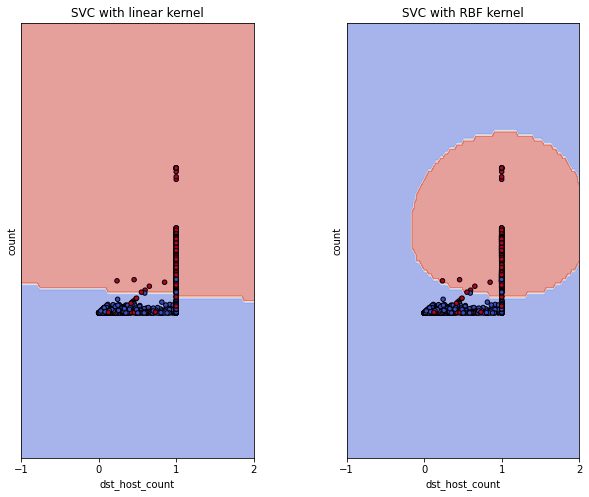

In [20]:
from sklearn.inspection import DecisionBoundaryDisplay
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    SVC(kernel="linear", C=1),
    SVC(kernel="rbf", gamma=0.7, C=1),
)
models = (clf.fit(X_train, y_train) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "SVC with RBF kernel"
)

# Set-up 1x2 grid for plotting.
fig, sub = plt.subplots(1, 2,figsize=(10, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_train[:, 0], X_train[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_train,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.5,
        ax=ax,
        xlabel="dst_host_count",
        ylabel="count",
    )
    ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks([-1,0,1,2])
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

#### Observations:
##### dst_host_count and count seem to affect the classification a lot since using these 2 alone gives us a classification with over 93% accuracy
##### On decreasing the number of features, the accuracy descreases significantly as expected.
##### The linear kernel draws a straight line to seperate the 2 labels.
##### the rbf kernel draws a circular/elliptical shape.
##### The difference in the accuracy is quite less indicatin that the data is largely linearly seperable.
##### Finetuning the hyperparameters does't affect the accuracy drastically.